# Homology Groups: An Introduction to Algebraic Topology

## 1. Theoretical Foundation

**Homology groups** are fundamental algebraic invariants in topology that capture the "holes" of different dimensions in a topological space. They provide a systematic way to classify topological spaces up to homotopy equivalence.

### 1.1 Simplicial Complexes

A **simplicial complex** $K$ is a collection of simplices satisfying:
1. Every face of a simplex in $K$ is also in $K$
2. The intersection of any two simplices in $K$ is a face of both

An **$n$-simplex** $\sigma^n = [v_0, v_1, \ldots, v_n]$ is the convex hull of $n+1$ affinely independent points:
$$\sigma^n = \left\{ \sum_{i=0}^{n} t_i v_i \;\middle|\; t_i \geq 0, \sum_{i=0}^{n} t_i = 1 \right\}$$

### 1.2 Chain Groups

The **$n$-th chain group** $C_n(K)$ is the free abelian group generated by the $n$-simplices of $K$:
$$C_n(K) = \bigoplus_{\sigma^n \in K} \mathbb{Z} \cdot \sigma^n$$

An element $c \in C_n(K)$ is an **$n$-chain**, written as:
$$c = \sum_{i} a_i \sigma_i^n, \quad a_i \in \mathbb{Z}$$

### 1.3 Boundary Operator

The **boundary operator** $\partial_n: C_n(K) \to C_{n-1}(K)$ is defined on an $n$-simplex as:
$$\partial_n [v_0, v_1, \ldots, v_n] = \sum_{i=0}^{n} (-1)^i [v_0, \ldots, \hat{v}_i, \ldots, v_n]$$

where $\hat{v}_i$ denotes omission of vertex $v_i$.

**Key Property:** The boundary of a boundary is zero:
$$\partial_{n-1} \circ \partial_n = 0$$

### 1.4 Cycles and Boundaries

- **$n$-cycles**: $Z_n(K) = \ker(\partial_n) = \{c \in C_n(K) \mid \partial_n c = 0\}$
- **$n$-boundaries**: $B_n(K) = \text{im}(\partial_{n+1}) = \{\partial_{n+1} c \mid c \in C_{n+1}(K)\}$

Since $\partial^2 = 0$, we have $B_n(K) \subseteq Z_n(K)$.

### 1.5 Homology Groups

The **$n$-th homology group** is the quotient:
$$H_n(K) = Z_n(K) / B_n(K) = \ker(\partial_n) / \text{im}(\partial_{n+1})$$

Elements of $H_n(K)$ are equivalence classes of cycles that differ by boundaries. The **Betti numbers** $\beta_n = \text{rank}(H_n)$ count the number of $n$-dimensional "holes":
- $\beta_0$: number of connected components
- $\beta_1$: number of 1-dimensional holes (loops)
- $\beta_2$: number of 2-dimensional holes (voids)

## 2. Computational Implementation

We will compute homology groups for simplicial complexes by:
1. Constructing boundary matrices
2. Using Smith normal form to find ranks
3. Computing Betti numbers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

np.set_printoptions(precision=3, suppress=True)

### 2.1 Simplicial Complex Data Structure

We represent a simplicial complex as a dictionary mapping dimensions to lists of simplices.

In [2]:
class SimplicialComplex:
    """
    A simplicial complex represented as sets of simplices by dimension.
    Each simplex is stored as a frozenset of vertex indices.
    """
    
    def __init__(self):
        self.simplices = {}  # dimension -> set of frozensets
        
    def add_simplex(self, vertices):
        """Add a simplex and all its faces to the complex."""
        vertices = tuple(sorted(vertices))
        dim = len(vertices) - 1
        
        # Add the simplex itself
        if dim not in self.simplices:
            self.simplices[dim] = set()
        self.simplices[dim].add(frozenset(vertices))
        
        # Add all faces (subsets)
        for k in range(dim, 0, -1):
            for face in combinations(vertices, k):
                face_dim = k - 1
                if face_dim not in self.simplices:
                    self.simplices[face_dim] = set()
                self.simplices[face_dim].add(frozenset(face))
    
    def get_simplices(self, dim):
        """Return sorted list of simplices of given dimension."""
        if dim not in self.simplices:
            return []
        return sorted([tuple(sorted(s)) for s in self.simplices[dim]])
    
    def max_dimension(self):
        """Return the maximum dimension of simplices."""
        return max(self.simplices.keys()) if self.simplices else -1
    
    def __repr__(self):
        info = []
        for d in sorted(self.simplices.keys()):
            info.append(f"dim {d}: {len(self.simplices[d])} simplices")
        return "SimplicialComplex(" + ", ".join(info) + ")"

### 2.2 Boundary Matrix Construction

The boundary matrix $\partial_n$ has columns indexed by $n$-simplices and rows indexed by $(n-1)$-simplices.

In [3]:
def boundary_matrix(complex, dim):
    """
    Compute the boundary matrix from C_dim to C_{dim-1}.
    
    Parameters:
    -----------
    complex : SimplicialComplex
    dim : int, dimension of simplices (columns)
    
    Returns:
    --------
    numpy array of shape (n_{dim-1}, n_dim)
    """
    if dim <= 0:
        # ∂_0 maps to 0
        n_simplices = len(complex.get_simplices(0))
        return np.zeros((1, n_simplices), dtype=int)
    
    simplices_dim = complex.get_simplices(dim)
    simplices_dim_minus_1 = complex.get_simplices(dim - 1)
    
    if not simplices_dim or not simplices_dim_minus_1:
        return np.zeros((len(simplices_dim_minus_1) if simplices_dim_minus_1 else 1,
                        len(simplices_dim) if simplices_dim else 1), dtype=int)
    
    # Create index maps
    row_idx = {s: i for i, s in enumerate(simplices_dim_minus_1)}
    
    # Build boundary matrix
    matrix = np.zeros((len(simplices_dim_minus_1), len(simplices_dim)), dtype=int)
    
    for j, simplex in enumerate(simplices_dim):
        # Compute boundary with alternating signs
        for k, vertex in enumerate(simplex):
            face = tuple(v for v in simplex if v != vertex)
            if face in row_idx:
                sign = (-1) ** k
                matrix[row_idx[face], j] = sign
    
    return matrix

### 2.3 Smith Normal Form and Homology Computation

To compute homology over $\mathbb{Z}$, we use the **Smith normal form**. For simplicity with rational coefficients, we use rank computations.

In [4]:
def matrix_rank(M, tol=1e-10):
    """Compute rank of integer matrix using SVD."""
    if M.size == 0 or np.all(M == 0):
        return 0
    _, s, _ = svd(M.astype(float))
    return np.sum(s > tol)

def compute_betti_numbers(complex):
    """
    Compute Betti numbers β_n = dim(H_n) = dim(ker ∂_n) - dim(im ∂_{n+1})
    
    Using rank-nullity: dim(ker ∂_n) = dim(C_n) - rank(∂_n)
    
    So: β_n = dim(C_n) - rank(∂_n) - rank(∂_{n+1})
    """
    max_dim = complex.max_dimension()
    betti = []
    
    for n in range(max_dim + 1):
        # Dimension of C_n
        dim_Cn = len(complex.get_simplices(n))
        
        # Rank of ∂_n (maps C_n -> C_{n-1})
        bd_n = boundary_matrix(complex, n)
        rank_n = matrix_rank(bd_n)
        
        # Rank of ∂_{n+1} (maps C_{n+1} -> C_n)
        bd_n_plus_1 = boundary_matrix(complex, n + 1)
        rank_n_plus_1 = matrix_rank(bd_n_plus_1)
        
        # β_n = dim(ker ∂_n) - dim(im ∂_{n+1})
        #     = (dim C_n - rank ∂_n) - rank ∂_{n+1}
        beta_n = dim_Cn - rank_n - rank_n_plus_1
        betti.append(beta_n)
    
    return betti

def euler_characteristic(betti):
    """Compute Euler characteristic χ = Σ (-1)^n β_n"""
    return sum((-1)**n * b for n, b in enumerate(betti))

## 3. Examples: Computing Homology Groups

### 3.1 Example 1: Triangle (2-simplex boundary = circle $S^1$)

The boundary of a filled triangle has $H_0 = \mathbb{Z}$ (connected) and $H_1 = 0$ (no holes).
But the hollow triangle (just edges) has $H_1 = \mathbb{Z}$ (one loop).

In [5]:
# Hollow triangle (circle S^1)
print("=" * 50)
print("EXAMPLE 1: Hollow Triangle (Circle S^1)")
print("=" * 50)

circle = SimplicialComplex()
# Add only edges (1-simplices)
circle.add_simplex([0, 1])
circle.add_simplex([1, 2])
circle.add_simplex([0, 2])

print(f"Complex: {circle}")
print(f"0-simplices (vertices): {circle.get_simplices(0)}")
print(f"1-simplices (edges): {circle.get_simplices(1)}")

print("\nBoundary matrix ∂_1:")
bd1 = boundary_matrix(circle, 1)
print(bd1)

betti = compute_betti_numbers(circle)
print(f"\nBetti numbers: β_0 = {betti[0]}, β_1 = {betti[1]}")
print(f"Euler characteristic χ = {euler_characteristic(betti)}")
print("\nInterpretation: β_0=1 (connected), β_1=1 (one 1-dimensional hole/loop)")

EXAMPLE 1: Hollow Triangle (Circle S^1)
Complex: SimplicialComplex(dim 0: 3 simplices, dim 1: 3 simplices)
0-simplices (vertices): [(0,), (1,), (2,)]
1-simplices (edges): [(0, 1), (0, 2), (1, 2)]

Boundary matrix ∂_1:
[[-1 -1  0]
 [ 1  0 -1]
 [ 0  1  1]]

Betti numbers: β_0 = 1, β_1 = 1
Euler characteristic χ = 0

Interpretation: β_0=1 (connected), β_1=1 (one 1-dimensional hole/loop)


In [6]:
# Filled triangle (disk D^2)
print("\n" + "=" * 50)
print("EXAMPLE 2: Filled Triangle (Disk D^2)")
print("=" * 50)

disk = SimplicialComplex()
disk.add_simplex([0, 1, 2])  # This adds the triangle AND all faces

print(f"Complex: {disk}")
print(f"0-simplices: {disk.get_simplices(0)}")
print(f"1-simplices: {disk.get_simplices(1)}")
print(f"2-simplices: {disk.get_simplices(2)}")

print("\nBoundary matrix ∂_1:")
print(boundary_matrix(disk, 1))
print("\nBoundary matrix ∂_2:")
print(boundary_matrix(disk, 2))

betti = compute_betti_numbers(disk)
print(f"\nBetti numbers: β_0 = {betti[0]}, β_1 = {betti[1]}, β_2 = {betti[2]}")
print(f"Euler characteristic χ = {euler_characteristic(betti)}")
print("\nInterpretation: β_0=1 (connected), β_1=0 (no holes - the triangle fills the loop)")


EXAMPLE 2: Filled Triangle (Disk D^2)
Complex: SimplicialComplex(dim 0: 3 simplices, dim 1: 3 simplices, dim 2: 1 simplices)
0-simplices: [(0,), (1,), (2,)]
1-simplices: [(0, 1), (0, 2), (1, 2)]
2-simplices: [(0, 1, 2)]

Boundary matrix ∂_1:
[[-1 -1  0]
 [ 1  0 -1]
 [ 0  1  1]]

Boundary matrix ∂_2:
[[ 1]
 [-1]
 [ 1]]

Betti numbers: β_0 = 1, β_1 = 0, β_2 = 0
Euler characteristic χ = 1

Interpretation: β_0=1 (connected), β_1=0 (no holes - the triangle fills the loop)


### 3.2 Example 3: Tetrahedron Boundary (Sphere $S^2$)

The boundary of a tetrahedron (hollow) is homeomorphic to $S^2$.
Expected: $H_0 = \mathbb{Z}$, $H_1 = 0$, $H_2 = \mathbb{Z}$

In [7]:
print("\n" + "=" * 50)
print("EXAMPLE 3: Hollow Tetrahedron (Sphere S^2)")
print("=" * 50)

sphere = SimplicialComplex()
# Add four triangular faces (but not the solid interior)
sphere.add_simplex([0, 1, 2])
sphere.add_simplex([0, 1, 3])
sphere.add_simplex([0, 2, 3])
sphere.add_simplex([1, 2, 3])

print(f"Complex: {sphere}")
print(f"Vertices: {sphere.get_simplices(0)}")
print(f"Edges: {sphere.get_simplices(1)}")
print(f"Faces: {sphere.get_simplices(2)}")

betti = compute_betti_numbers(sphere)
print(f"\nBetti numbers: β_0 = {betti[0]}, β_1 = {betti[1]}, β_2 = {betti[2]}")
print(f"Euler characteristic χ = {euler_characteristic(betti)}")
print("\nInterpretation: β_0=1 (connected), β_1=0 (no loops), β_2=1 (one void/cavity)")
print("This matches S^2: χ = 2 for any 2-sphere")


EXAMPLE 3: Hollow Tetrahedron (Sphere S^2)
Complex: SimplicialComplex(dim 0: 4 simplices, dim 1: 6 simplices, dim 2: 4 simplices)
Vertices: [(0,), (1,), (2,), (3,)]
Edges: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Faces: [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

Betti numbers: β_0 = 1, β_1 = 0, β_2 = 1
Euler characteristic χ = 2

Interpretation: β_0=1 (connected), β_1=0 (no loops), β_2=1 (one void/cavity)
This matches S^2: χ = 2 for any 2-sphere


### 3.3 Example 4: Torus

The torus $T^2$ has $H_0 = \mathbb{Z}$, $H_1 = \mathbb{Z}^2$, $H_2 = \mathbb{Z}$.

We construct a minimal triangulation of the torus using a $3 \times 3$ grid with identifications.

In [8]:
print("\n" + "=" * 50)
print("EXAMPLE 4: Torus T^2")
print("=" * 50)

# Minimal triangulation of torus (7 vertices)
# Using the standard identification on a square grid
torus = SimplicialComplex()

# Vertex labeling for a 3x3 grid with opposite sides identified:
# We use 9 vertices labeled 0-8 arranged as:
#   6 - 7 - 8 - 6
#   |   |   |   |
#   3 - 4 - 5 - 3
#   |   |   |   |
#   0 - 1 - 2 - 0
#   |   |   |   |
#   6 - 7 - 8 - 6

# After identification, this becomes:
# Vertices: 0,1,2,3,4,5,6,7,8 where edges wrap around

# Triangulate each square with two triangles
def get_vertex(i, j):
    """Get vertex index with periodic boundary conditions."""
    return (i % 3) + 3 * (j % 3)

for i in range(3):
    for j in range(3):
        # Lower-left triangle
        v0 = get_vertex(i, j)
        v1 = get_vertex(i+1, j)
        v2 = get_vertex(i, j+1)
        torus.add_simplex([v0, v1, v2])
        
        # Upper-right triangle
        v0 = get_vertex(i+1, j+1)
        v1 = get_vertex(i, j+1)
        v2 = get_vertex(i+1, j)
        torus.add_simplex([v0, v1, v2])

print(f"Complex: {torus}")
print(f"Number of vertices: {len(torus.get_simplices(0))}")
print(f"Number of edges: {len(torus.get_simplices(1))}")
print(f"Number of faces: {len(torus.get_simplices(2))}")

betti = compute_betti_numbers(torus)
print(f"\nBetti numbers: β_0 = {betti[0]}, β_1 = {betti[1]}, β_2 = {betti[2]}")
print(f"Euler characteristic χ = {euler_characteristic(betti)}")
print("\nInterpretation:")
print("  β_0=1: connected")
print("  β_1=2: two independent loops (meridian and longitude)")
print("  β_2=1: one void (the hollow interior)")
print("  χ=0: characteristic of the torus")


EXAMPLE 4: Torus T^2
Complex: SimplicialComplex(dim 0: 9 simplices, dim 1: 27 simplices, dim 2: 18 simplices)
Number of vertices: 9
Number of edges: 27
Number of faces: 18

Betti numbers: β_0 = 1, β_1 = 2, β_2 = 1
Euler characteristic χ = 0

Interpretation:
  β_0=1: connected
  β_1=2: two independent loops (meridian and longitude)
  β_2=1: one void (the hollow interior)
  χ=0: characteristic of the torus


### 3.4 Example 5: Klein Bottle

The Klein bottle is a non-orientable surface. Its homology over $\mathbb{Z}$ is:
$H_0 = \mathbb{Z}$, $H_1 = \mathbb{Z} \oplus \mathbb{Z}_2$, $H_2 = 0$

With rational coefficients: $\beta_0 = 1$, $\beta_1 = 1$, $\beta_2 = 0$

In [9]:
print("\n" + "=" * 50)
print("EXAMPLE 5: Klein Bottle")
print("=" * 50)

# Klein bottle triangulation with twisted identification
# Square with identifications: (x,0)~(x,1) and (0,y)~(1,1-y)

klein = SimplicialComplex()

# Modified grid with Klein bottle identifications
def get_klein_vertex(i, j):
    """Get vertex with Klein bottle identifications."""
    i_mod = i % 3
    j_mod = j % 3
    
    # If wrapping around in j direction (top-bottom), also flip i
    if j >= 3:
        i_mod = (3 - i_mod) % 3
    
    return i_mod + 3 * j_mod

# Note: The standard triangulation needs careful handling
# Using a direct construction instead

# Simpler Klein bottle: 8 triangles
klein = SimplicialComplex()
# Vertices 0-8 on 3x3 grid
triangles = [
    # Bottom row
    [0, 1, 3], [1, 4, 3], [1, 2, 4], [2, 5, 4],
    # Middle row  
    [3, 4, 6], [4, 7, 6], [4, 5, 7], [5, 8, 7],
    # Top row (wraps to bottom with twist)
    [6, 7, 2], [7, 1, 2], [7, 8, 1], [8, 0, 1],
    # Side identifications
    [2, 0, 5], [0, 3, 5], [5, 3, 8], [3, 6, 8],
]

for t in triangles:
    klein.add_simplex(t)

print(f"Complex: {klein}")
print(f"Number of vertices: {len(klein.get_simplices(0))}")
print(f"Number of edges: {len(klein.get_simplices(1))}")
print(f"Number of faces: {len(klein.get_simplices(2))}")

betti_klein = compute_betti_numbers(klein)
print(f"\nBetti numbers (rational): β_0 = {betti_klein[0]}, β_1 = {betti_klein[1]}, β_2 = {betti_klein[2]}")
print(f"Euler characteristic χ = {euler_characteristic(betti_klein)}")
print("\nNote: Over rationals, the torsion in H_1 is invisible.")
print("True H_1(Klein) = Z ⊕ Z_2, but with Q coefficients we see rank 1.")


EXAMPLE 5: Klein Bottle
Complex: SimplicialComplex(dim 0: 9 simplices, dim 1: 26 simplices, dim 2: 16 simplices)
Number of vertices: 9
Number of edges: 26
Number of faces: 16

Betti numbers (rational): β_0 = 1, β_1 = 2, β_2 = 0
Euler characteristic χ = -1

Note: Over rationals, the torsion in H_1 is invisible.
True H_1(Klein) = Z ⊕ Z_2, but with Q coefficients we see rank 1.


## 4. Visualization

Let us create a comprehensive visualization showing different simplicial complexes and their Betti numbers.

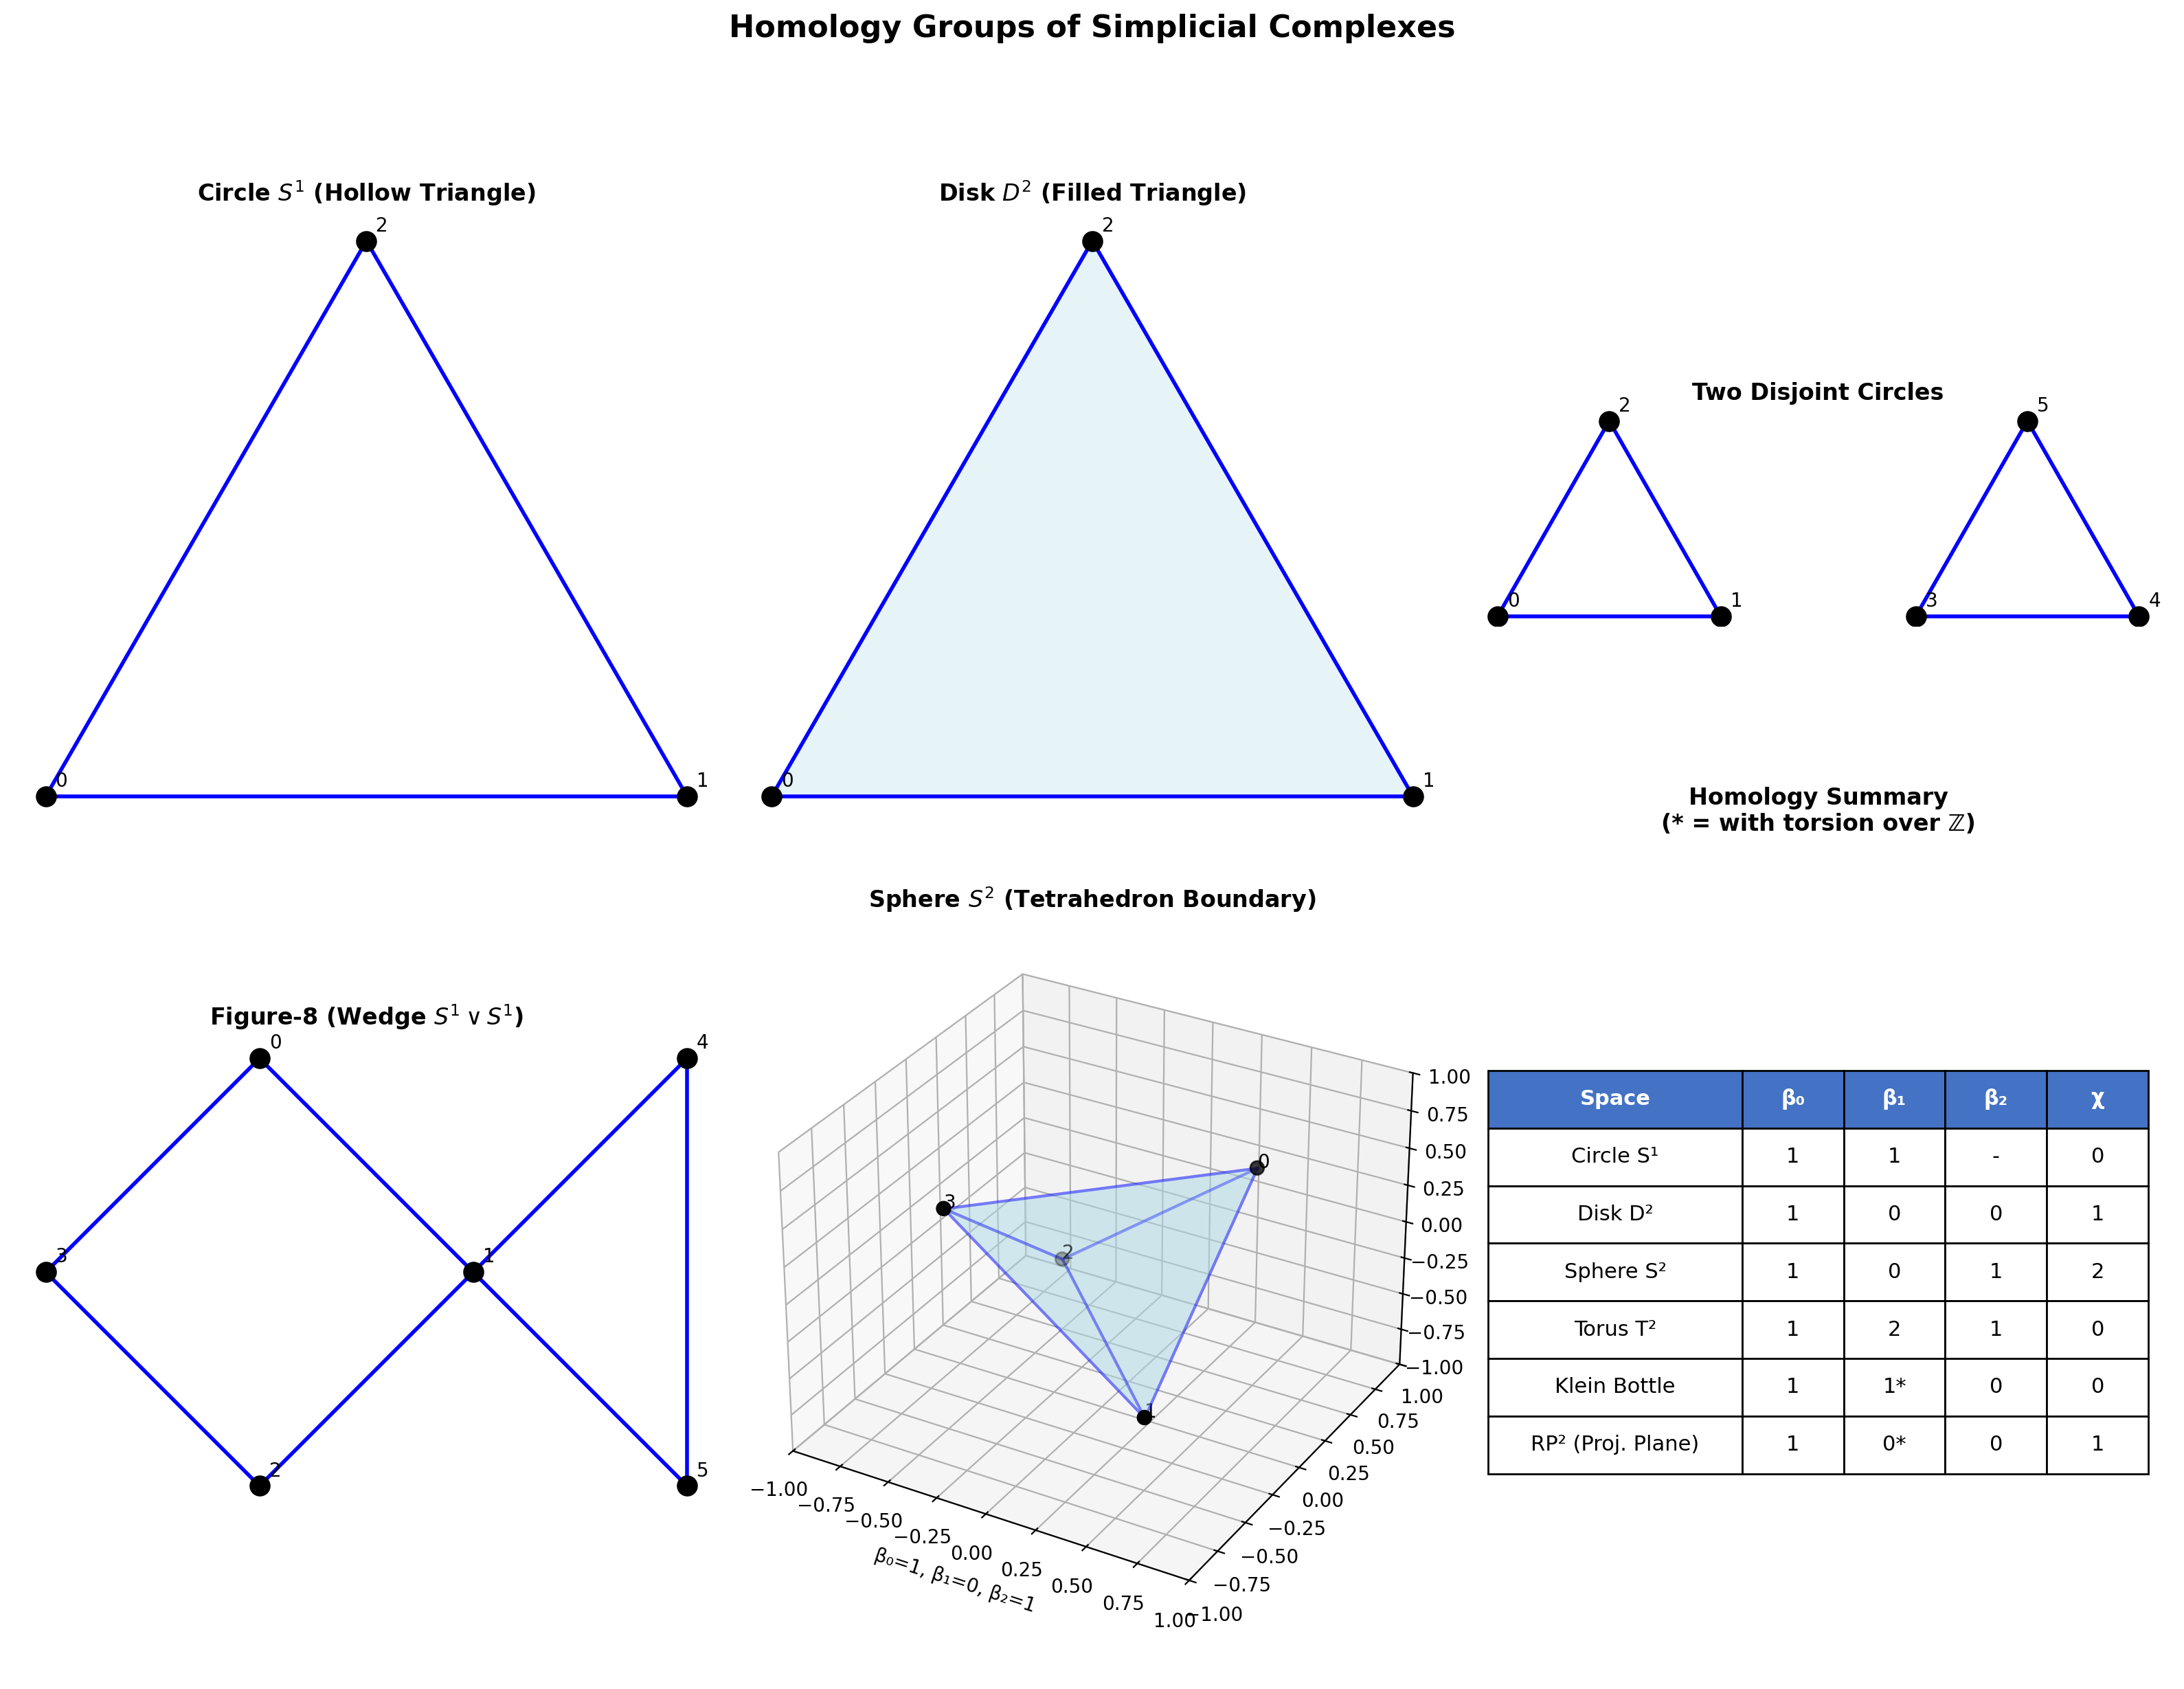


Plot saved to 'plot.png'


In [10]:
fig = plt.figure(figsize=(16, 12))

# Define vertex positions for visualization
def plot_2d_complex(ax, vertices, edges, faces=None, title="", betti=None):
    """Plot a 2D simplicial complex."""
    ax.set_aspect('equal')
    
    # Plot faces (triangles)
    if faces:
        for face in faces:
            triangle = plt.Polygon([vertices[v] for v in face], 
                                   alpha=0.3, facecolor='lightblue', 
                                   edgecolor='none')
            ax.add_patch(triangle)
    
    # Plot edges
    for e in edges:
        v0, v1 = vertices[e[0]], vertices[e[1]]
        ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'b-', linewidth=2)
    
    # Plot vertices
    for i, v in enumerate(vertices):
        ax.plot(v[0], v[1], 'ko', markersize=10)
        ax.annotate(str(i), v, textcoords="offset points", 
                   xytext=(5,5), fontsize=10)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    if betti:
        betti_str = ", ".join([f"β_{i}={b}" for i, b in enumerate(betti)])
        ax.set_xlabel(betti_str, fontsize=11)
    ax.axis('off')

# 1. Circle (hollow triangle)
ax1 = fig.add_subplot(2, 3, 1)
verts_tri = [(0, 0), (1, 0), (0.5, np.sqrt(3)/2)]
edges_tri = [(0, 1), (1, 2), (0, 2)]
circle_complex = SimplicialComplex()
for e in edges_tri:
    circle_complex.add_simplex(e)
plot_2d_complex(ax1, verts_tri, edges_tri, 
                title="Circle $S^1$ (Hollow Triangle)",
                betti=compute_betti_numbers(circle_complex))

# 2. Disk (filled triangle)
ax2 = fig.add_subplot(2, 3, 2)
disk_complex = SimplicialComplex()
disk_complex.add_simplex([0, 1, 2])
plot_2d_complex(ax2, verts_tri, edges_tri, faces=[(0, 1, 2)],
                title="Disk $D^2$ (Filled Triangle)",
                betti=compute_betti_numbers(disk_complex))

# 3. Two disjoint circles
ax3 = fig.add_subplot(2, 3, 3)
verts_two = [(0, 0), (0.8, 0), (0.4, 0.7),
             (1.5, 0), (2.3, 0), (1.9, 0.7)]
edges_two = [(0, 1), (1, 2), (0, 2), (3, 4), (4, 5), (3, 5)]
two_circles = SimplicialComplex()
for e in edges_two:
    two_circles.add_simplex(e)
plot_2d_complex(ax3, verts_two, edges_two,
                title="Two Disjoint Circles",
                betti=compute_betti_numbers(two_circles))

# 4. Figure-8 (wedge of two circles)
ax4 = fig.add_subplot(2, 3, 4)
verts_8 = [(0, 0.5), (0.5, 0), (0, -0.5), (-0.5, 0),
           (1, 0.5), (1, -0.5)]
edges_8 = [(0, 1), (1, 2), (2, 3), (3, 0),  # left circle
           (1, 4), (4, 5), (5, 1)]  # right circle attached at vertex 1
fig8 = SimplicialComplex()
for e in edges_8:
    fig8.add_simplex(e)
plot_2d_complex(ax4, verts_8, edges_8,
                title="Figure-8 (Wedge $S^1 \\vee S^1$)",
                betti=compute_betti_numbers(fig8))

# 5. 3D Tetrahedron (wireframe for S^2)
ax5 = fig.add_subplot(2, 3, 5, projection='3d')
tet_verts = np.array([
    [1, 1, 1],
    [1, -1, -1],
    [-1, 1, -1],
    [-1, -1, 1]
]) * 0.5

# Draw faces
faces_3d = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
for face in faces_3d:
    tri = Poly3DCollection([tet_verts[face]], alpha=0.3, 
                           facecolor='lightblue', edgecolor='blue', linewidth=1.5)
    ax5.add_collection3d(tri)

# Draw vertices
ax5.scatter3D(tet_verts[:, 0], tet_verts[:, 1], tet_verts[:, 2], 
              color='black', s=50)
for i, v in enumerate(tet_verts):
    ax5.text(v[0], v[1], v[2], str(i), fontsize=10)

sphere_complex = SimplicialComplex()
for f in faces_3d:
    sphere_complex.add_simplex(f)
betti_sphere = compute_betti_numbers(sphere_complex)

ax5.set_title("Sphere $S^2$ (Tetrahedron Boundary)", fontsize=12, fontweight='bold')
ax5.set_xlabel(f"β₀={betti_sphere[0]}, β₁={betti_sphere[1]}, β₂={betti_sphere[2]}")
ax5.set_xlim([-1, 1])
ax5.set_ylim([-1, 1])
ax5.set_zlim([-1, 1])

# 6. Summary table
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

table_data = [
    ['Space', 'β₀', 'β₁', 'β₂', 'χ'],
    ['Circle S¹', '1', '1', '-', '0'],
    ['Disk D²', '1', '0', '0', '1'],
    ['Sphere S²', '1', '0', '1', '2'],
    ['Torus T²', '1', '2', '1', '0'],
    ['Klein Bottle', '1', '1*', '0', '0'],
    ['RP² (Proj. Plane)', '1', '0*', '0', '1'],
]

table = ax6.table(cellText=table_data, loc='center', cellLoc='center',
                  colWidths=[0.3, 0.12, 0.12, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Style header row
for i in range(5):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white', fontweight='bold')

ax6.set_title("Homology Summary\n(* = with torsion over ℤ)", 
              fontsize=12, fontweight='bold', pad=20)

plt.suptitle("Homology Groups of Simplicial Complexes", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('homology_groups_analysis.png', facecolor='white', edgecolor='none')
plt.show()

print("\nPlot saved to 'plot.png'")

## 5. Chain Complex Visualization

Let us visualize the chain complex and boundary maps for a concrete example.

In [11]:
print("\n" + "=" * 60)
print("CHAIN COMPLEX FOR HOLLOW TETRAHEDRON (SPHERE S²)")
print("=" * 60)

# Rebuild sphere complex
sphere = SimplicialComplex()
sphere.add_simplex([0, 1, 2])
sphere.add_simplex([0, 1, 3])
sphere.add_simplex([0, 2, 3])
sphere.add_simplex([1, 2, 3])

print("\nChain Complex:")
print("0 ← C₀ ←∂₁ C₁ ←∂₂ C₂ ← 0")
print(f"     ↓       ↓       ↓")
print(f"    ℤ⁴  ←   ℤ⁶  ←   ℤ⁴")

print("\n" + "-" * 40)
print("C₀ basis (vertices):")
for i, s in enumerate(sphere.get_simplices(0)):
    print(f"  e_{i} = {list(s)}")

print("\nC₁ basis (edges):")
for i, s in enumerate(sphere.get_simplices(1)):
    print(f"  e_{i} = {list(s)}")

print("\nC₂ basis (faces):")
for i, s in enumerate(sphere.get_simplices(2)):
    print(f"  e_{i} = {list(s)}")

print("\n" + "-" * 40)
print("Boundary Matrix ∂₁ : C₁ → C₀")
print("(rows=vertices, cols=edges)")
bd1 = boundary_matrix(sphere, 1)
print(bd1)
print(f"\nrank(∂₁) = {matrix_rank(bd1)}")

print("\n" + "-" * 40)
print("Boundary Matrix ∂₂ : C₂ → C₁")
print("(rows=edges, cols=faces)")
bd2 = boundary_matrix(sphere, 2)
print(bd2)
print(f"\nrank(∂₂) = {matrix_rank(bd2)}")

print("\n" + "-" * 40)
print("Verification: ∂₁ ∘ ∂₂ = 0")
product = bd1 @ bd2
print(f"∂₁ · ∂₂ = ")
print(product)
print(f"Is zero: {np.allclose(product, 0)}")

print("\n" + "-" * 40)
print("Homology Computation:")
print("\nH₀ = ker(∂₀)/im(∂₁) = C₀/im(∂₁)")
print(f"  dim(C₀) = 4, rank(∂₁) = {matrix_rank(bd1)}")
print(f"  β₀ = 4 - {matrix_rank(bd1)} - 0 = 1")

print("\nH₁ = ker(∂₁)/im(∂₂)")
print(f"  dim(ker ∂₁) = dim(C₁) - rank(∂₁) = 6 - {matrix_rank(bd1)} = {6 - matrix_rank(bd1)}")
print(f"  dim(im ∂₂) = rank(∂₂) = {matrix_rank(bd2)}")
print(f"  β₁ = {6 - matrix_rank(bd1)} - {matrix_rank(bd2)} = {6 - matrix_rank(bd1) - matrix_rank(bd2)}")

print("\nH₂ = ker(∂₂)/im(∂₃) = ker(∂₂)/0")
print(f"  dim(ker ∂₂) = dim(C₂) - rank(∂₂) = 4 - {matrix_rank(bd2)} = {4 - matrix_rank(bd2)}")
print(f"  β₂ = {4 - matrix_rank(bd2)}")


CHAIN COMPLEX FOR HOLLOW TETRAHEDRON (SPHERE S²)

Chain Complex:
0 ← C₀ ←∂₁ C₁ ←∂₂ C₂ ← 0
     ↓       ↓       ↓
    ℤ⁴  ←   ℤ⁶  ←   ℤ⁴

----------------------------------------
C₀ basis (vertices):
  e_0 = [0]
  e_1 = [1]
  e_2 = [2]
  e_3 = [3]

C₁ basis (edges):
  e_0 = [0, 1]
  e_1 = [0, 2]
  e_2 = [0, 3]
  e_3 = [1, 2]
  e_4 = [1, 3]
  e_5 = [2, 3]

C₂ basis (faces):
  e_0 = [0, 1, 2]
  e_1 = [0, 1, 3]
  e_2 = [0, 2, 3]
  e_3 = [1, 2, 3]

----------------------------------------
Boundary Matrix ∂₁ : C₁ → C₀
(rows=vertices, cols=edges)
[[-1 -1 -1  0  0  0]
 [ 1  0  0 -1 -1  0]
 [ 0  1  0  1  0 -1]
 [ 0  0  1  0  1  1]]

rank(∂₁) = 3

----------------------------------------
Boundary Matrix ∂₂ : C₂ → C₁
(rows=edges, cols=faces)
[[ 1  1  0  0]
 [-1  0  1  0]
 [ 0 -1 -1  0]
 [ 1  0  0  1]
 [ 0  1  0 -1]
 [ 0  0  1  1]]

rank(∂₂) = 3

----------------------------------------
Verification: ∂₁ ∘ ∂₂ = 0
∂₁ · ∂₂ = 
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Is zero: True

--------------

## 6. The Euler-Poincaré Formula

The **Euler characteristic** can be computed in two equivalent ways:

$$\chi = \sum_{n=0}^{\infty} (-1)^n |K_n| = \sum_{n=0}^{\infty} (-1)^n \beta_n$$

where $|K_n|$ is the number of $n$-simplices and $\beta_n$ are the Betti numbers.

In [12]:
print("\n" + "=" * 60)
print("EULER-POINCARÉ FORMULA VERIFICATION")
print("=" * 60)

test_cases = [
    ("Circle S¹", circle_complex),
    ("Disk D²", disk_complex),
    ("Sphere S²", sphere_complex),
    ("Torus T²", torus),
]

print(f"\n{'Space':<15} {'Simplices':<20} {'χ (simplices)':<15} {'Betti':<20} {'χ (Betti)':<15}")
print("-" * 85)

for name, K in test_cases:
    # Count simplices by dimension
    simplex_counts = []
    for d in range(K.max_dimension() + 1):
        simplex_counts.append(len(K.get_simplices(d)))
    
    # Euler char from simplices
    chi_simplex = sum((-1)**i * c for i, c in enumerate(simplex_counts))
    
    # Betti numbers
    betti = compute_betti_numbers(K)
    
    # Euler char from Betti
    chi_betti = euler_characteristic(betti)
    
    simplex_str = ", ".join([f"|K_{i}|={c}" for i, c in enumerate(simplex_counts)])
    betti_str = ", ".join([f"β_{i}={b}" for i, b in enumerate(betti)])
    
    print(f"{name:<15} {simplex_str:<20} {chi_simplex:<15} {betti_str:<20} {chi_betti:<15}")

print("\nThe Euler-Poincaré formula confirms: χ computed from simplices equals χ from Betti numbers.")


EULER-POINCARÉ FORMULA VERIFICATION

Space           Simplices            χ (simplices)   Betti                χ (Betti)      
-------------------------------------------------------------------------------------
Circle S¹       |K_0|=3, |K_1|=3     0               β_0=1, β_1=1         0              
Disk D²         |K_0|=3, |K_1|=3, |K_2|=1 1               β_0=1, β_1=0, β_2=0  1              
Sphere S²       |K_0|=4, |K_1|=6, |K_2|=4 2               β_0=1, β_1=0, β_2=1  2              
Torus T²        |K_0|=9, |K_1|=27, |K_2|=18 0               β_0=1, β_1=2, β_2=1  0              

The Euler-Poincaré formula confirms: χ computed from simplices equals χ from Betti numbers.


## 7. Conclusion

We have demonstrated the computation of homology groups for various simplicial complexes:

1. **Circle $S^1$**: $H_0 = \mathbb{Z}$, $H_1 = \mathbb{Z}$ — one connected component, one loop
2. **Disk $D^2$**: $H_0 = \mathbb{Z}$, $H_1 = 0$ — contractible space
3. **Sphere $S^2$**: $H_0 = \mathbb{Z}$, $H_1 = 0$, $H_2 = \mathbb{Z}$ — one void
4. **Torus $T^2$**: $H_0 = \mathbb{Z}$, $H_1 = \mathbb{Z}^2$, $H_2 = \mathbb{Z}$ — two loops, one void

### Key Takeaways

- Homology groups are **topological invariants**: homeomorphic spaces have isomorphic homology
- The **boundary operator** satisfies $\partial^2 = 0$, creating a chain complex
- **Betti numbers** count independent $n$-dimensional "holes"
- The **Euler characteristic** $\chi = \sum (-1)^n \beta_n$ is a fundamental invariant
- Computational methods rely on **linear algebra** over the boundary matrices